In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.optim import SGD, Adam
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


torch.manual_seed(42)

## DATA
- [ml-latest-small](https://grouplens.org/datasets/movielens/latest/) 

In [2]:
raw_data = pd.read_csv("ratings.csv")
item_data = pd.read_csv("movies.csv")

'''
movie id의 값  : [     1      3      6 ... 160836 163937 163981]
movie id의 개수 : 9724
{0:1}, {1:3}, ... , {9723:163981} 이런 형태로 id를 idx로 맵핑해준 데이터로 변환해서 사용
최종 추천 결과를 출력할 때는, idx를 id로 맵핑한 결과를 보여주도록 함

user id의 경우 [1,2,..., 609, 610], 개수는 610
idx로 쓰려면 전체에 1을 빼주면 되지만, 편의를 위해 movie id처럼 맵핑해서 사용
{0:1}, {1:2}, ... , {609:610}
'''
item2idx, idx2item = {}, {}
user2idx, idx2user = {}, {}
id2title = {}

for idx, user_id in enumerate(np.unique(raw_data["userId"])):
    user2idx[user_id] = idx
    idx2user[idx] = user_id
for idx, item_id in enumerate(np.unique(raw_data["movieId"])):
    item2idx[item_id] = idx
    idx2item[idx] = item_id

# movieId - title mapping, 학습에 사용X, 후에 결과 출력에 사용하기 위함
for i in range(item_data.shape[0]):
    item_id = item_data.movieId[i]
    id2title[item_id] = item_data.title[i]

# make index data
index_data = raw_data.copy()
index_data["userId"] = raw_data["userId"].apply(lambda idx:user2idx[idx])
index_data["movieId"] = raw_data["movieId"].apply(lambda idx:item2idx[idx])

n_user = np.unique(raw_data["userId"]).shape[0]
n_item = np.unique(raw_data["movieId"]).shape[0]

In [3]:
index_data[["userId", "movieId"]]

,userId,movieId
0,0,0
1,0,2
2,0,5
3,0,43
4,0,46
...,...,...
100831,609,9416
100832,609,9443
100833,609,9444
100834,609,9445


- rating의 분포

<BarContainer object of 10 artists>

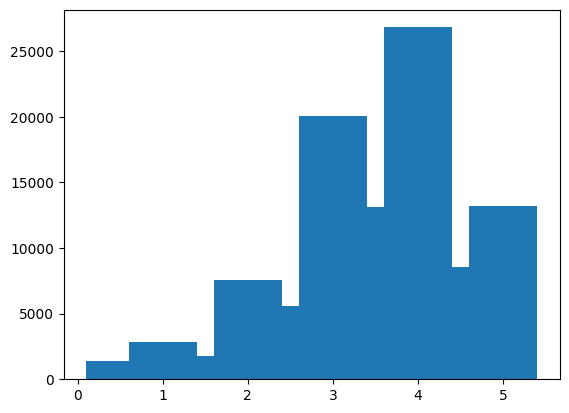

In [59]:
plt.bar(raw_data.rating.value_counts().index, raw_data.rating.value_counts())

In [4]:

class MovieLensDataset(Dataset):
    def __init__(self, data: pd.DataFrame, Binclf: bool = False):
        self.data = data
        self.Binclf = Binclf
        self.items = torch.tensor(self.data[["userId", "movieId"]].values)
        self.targets = torch.tensor(self.data.rating.values)
        self.field_dims = torch.max(self.items, axis=0).values + torch.tensor([1])
        self.user_field_idx = torch.tensor([0])
        self.item_field_idx = torch.tensor([0])

        if self.Binclf:
            self.__target2Bin()

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> tuple[torch.tensor, torch.tensor]:
        return self.items[idx], self.targets[idx]

    def __target2Bin(self):
        self.targets[self.targets <= 3] = 0
        self.targets[self.targets > 3] = 1

## Model 

- Linear term     
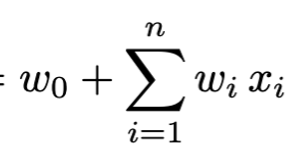

In [5]:
class FeatureLinear(nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = nn.Embedding(sum(field_dims), output_dim) # (n_user+n_item, output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,))) # global bias
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int_) # [0, n_user]

    def forward(self, x):
        '''
        x : long tensor of size (batch, num_fields)
            user, item
        row   .    .
        row   .    .
        '''
        x = x + x.new_tensor(self.offsets).unsqueeze(0) # item의 id에 유저의 수만큼 더해줌 103을 맞추기 위함
        return torch.sum(self.fc(x), dim=1) + self.bias 

- FeatureEmbedding : V

In [6]:
class FeatureEmbedding(nn.Module):
    def __init__(self, field_dims, embed_dim=16):
        super().__init__()
        self.embedding = nn.Embedding(sum(field_dims), embed_dim) # (n_user+n_item, output_dim), 유저가 100명일 때, 아이템 3번의 위치는 103이 됨
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.int_) # [0, n_user]
        nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        '''
        x : long tensor of size (batch, num_fields)
            user, item
        row
        row
        '''
        x = x + x.new_tensor(self.offsets).unsqueeze(0) # item의 id에 유저의 수만큼 더해줌 103을 맞추기 위함
        return self.embedding(x)

- ix   
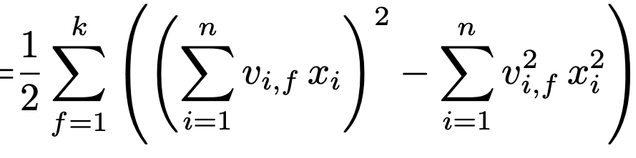
- model eq   
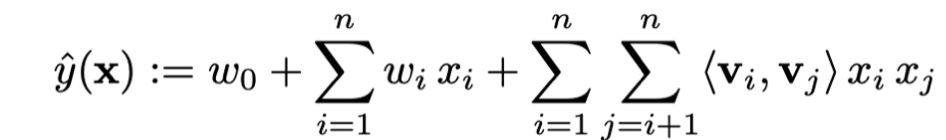

In [7]:
class FM(nn.Module):
    def __init__(self, field_dims, embed_dim=16, clf=False):
        super().__init__()
        self.linear = FeatureLinear(field_dims)
        self.embedding = FeatureEmbedding(field_dims, embed_dim)
        self.clf = clf

    def forward(self, x):
        '''
        x : float tensor of size (batch, num_fields)
            user, item
        row
        row
        '''
        square_of_sum = torch.sum(self.embedding(x),dim=1)**2
        sum_of_square = torch.sum(self.embedding(x)**2, dim=1)
        ix = 0.5*(torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True))
        x = self.linear(x) + ix
        if self.clf:
            return torch.sigmoid(x.squeeze(1))
        return x.squeeze(1)


## trainer

In [8]:
def train(model, optimizer, dataloader, criterion, device):
    model.train()
    total_loss = 0

    for fields, target in tqdm(dataloader):

        fields = fields.to(device)
        target = target.to(device)

        out = model(fields).double()
        loss = criterion(out, target)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(dataloader)


def eval(model, dataloader, device, criterion):
    model.eval()
    preds = []
    total_loss = 0

    with torch.no_grad():
        for fields, target in dataloader:
            fields = fields.to(device)
            target = target.to(device)

            out = model(fields).double()
            total_loss += criterion(out, target)

            preds.extend(out)

    return torch.tensor(preds), total_loss / len(dataloader)

In [9]:
def RMSE(actual, pred):
    mse = nn.MSELoss()
    eps = 1e-6
    return torch.sqrt(mse(pred, actual)+eps)

## Main
- Reg case

In [10]:
# Hyper parameters
embed_dim = 70
batch_size = 1024
epochs = 70
lr = 0.005
weight_decay = 0.001
device = 'cpu'
optimizer = "Adam"
optims = {"SGD": SGD, "Adam": Adam}
Binclf = False

In [11]:
dataset = MovieLensDataset(index_data, Binclf)
train_len = int(len(dataset)*0.8)
valid_len = int(len(dataset)*0.1)
test_len = len(dataset) - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, (train_len, valid_len, test_len))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
field_dims = dataset.field_dims

model = FM(field_dims, embed_dim, Binclf)
criterion = nn.BCELoss() if Binclf else RMSE
metric = roc_auc_score if Binclf else RMSE

In [13]:
best_loss = 1e5
best_epoch = 1
all_train_loss = []
all_valid_loss = []

for epoch in range(1, epochs+1):
    train_loss = train(model, optims[optimizer](params=model.parameters(), lr=lr, weight_decay=weight_decay), train_dataloader, criterion, device)
    pred, valid_loss = eval(model, valid_dataloader, device, criterion)

    print(f'EPOCH : {epoch:2} | Train Loss : {train_loss:.6f} | Valid Loss : {valid_loss:.6f}')
    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch

print(f'BEST EPOCH : {best_epoch} | Best Valid Loss : {best_loss}')

100%|██████████| 79/79 [00:00<00:00, 133.14it/s]


EPOCH :  1 | Train Loss : 3.542120 | Valid Loss : 3.042757


100%|██████████| 79/79 [00:00<00:00, 112.82it/s]


EPOCH :  2 | Train Loss : 2.646034 | Valid Loss : 2.221619


100%|██████████| 79/79 [00:00<00:00, 124.66it/s]


EPOCH :  3 | Train Loss : 2.026772 | Valid Loss : 1.768031


100%|██████████| 79/79 [00:00<00:00, 124.30it/s]


EPOCH :  4 | Train Loss : 1.632806 | Valid Loss : 1.448371


100%|██████████| 79/79 [00:00<00:00, 113.37it/s]


EPOCH :  5 | Train Loss : 1.331962 | Valid Loss : 1.204384


100%|██████████| 79/79 [00:00<00:00, 123.85it/s]


EPOCH :  6 | Train Loss : 1.111611 | Valid Loss : 1.042360


100%|██████████| 79/79 [00:00<00:00, 124.70it/s]


EPOCH :  7 | Train Loss : 0.990750 | Valid Loss : 0.970213


100%|██████████| 79/79 [00:00<00:00, 118.51it/s]


EPOCH :  8 | Train Loss : 0.943755 | Valid Loss : 0.943542


100%|██████████| 79/79 [00:00<00:00, 122.66it/s]


EPOCH :  9 | Train Loss : 0.926925 | Valid Loss : 0.932549


100%|██████████| 79/79 [00:00<00:00, 124.19it/s]


EPOCH : 10 | Train Loss : 0.919453 | Valid Loss : 0.927220


100%|██████████| 79/79 [00:00<00:00, 123.12it/s]


EPOCH : 11 | Train Loss : 0.915669 | Valid Loss : 0.924352


100%|██████████| 79/79 [00:00<00:00, 124.61it/s]


EPOCH : 12 | Train Loss : 0.913657 | Valid Loss : 0.922671


100%|██████████| 79/79 [00:00<00:00, 124.06it/s]


EPOCH : 13 | Train Loss : 0.912503 | Valid Loss : 0.921621


100%|██████████| 79/79 [00:00<00:00, 124.24it/s]


EPOCH : 14 | Train Loss : 0.911800 | Valid Loss : 0.920944


100%|██████████| 79/79 [00:00<00:00, 124.64it/s]


EPOCH : 15 | Train Loss : 0.911367 | Valid Loss : 0.920498


100%|██████████| 79/79 [00:00<00:00, 122.88it/s]


EPOCH : 16 | Train Loss : 0.911075 | Valid Loss : 0.920177


100%|██████████| 79/79 [00:00<00:00, 124.42it/s]


EPOCH : 17 | Train Loss : 0.910880 | Valid Loss : 0.919952


100%|██████████| 79/79 [00:00<00:00, 124.40it/s]


EPOCH : 18 | Train Loss : 0.910742 | Valid Loss : 0.919796


100%|██████████| 79/79 [00:00<00:00, 124.09it/s]


EPOCH : 19 | Train Loss : 0.910645 | Valid Loss : 0.919686


100%|██████████| 79/79 [00:00<00:00, 125.55it/s]


EPOCH : 20 | Train Loss : 0.910577 | Valid Loss : 0.919600


100%|██████████| 79/79 [00:00<00:00, 123.72it/s]


EPOCH : 21 | Train Loss : 0.910529 | Valid Loss : 0.919542


100%|██████████| 79/79 [00:00<00:00, 124.42it/s]


EPOCH : 22 | Train Loss : 0.910494 | Valid Loss : 0.919496


100%|██████████| 79/79 [00:00<00:00, 124.58it/s]


EPOCH : 23 | Train Loss : 0.910465 | Valid Loss : 0.919464


100%|██████████| 79/79 [00:00<00:00, 125.32it/s]


EPOCH : 24 | Train Loss : 0.910445 | Valid Loss : 0.919437


100%|██████████| 79/79 [00:00<00:00, 124.52it/s]


EPOCH : 25 | Train Loss : 0.910431 | Valid Loss : 0.919420


100%|██████████| 79/79 [00:00<00:00, 123.68it/s]


EPOCH : 26 | Train Loss : 0.910418 | Valid Loss : 0.919404


100%|██████████| 79/79 [00:00<00:00, 123.65it/s]


EPOCH : 27 | Train Loss : 0.910410 | Valid Loss : 0.919393


100%|██████████| 79/79 [00:00<00:00, 124.95it/s]


EPOCH : 28 | Train Loss : 0.910404 | Valid Loss : 0.919385


100%|██████████| 79/79 [00:00<00:00, 124.96it/s]


EPOCH : 29 | Train Loss : 0.910399 | Valid Loss : 0.919379


100%|██████████| 79/79 [00:00<00:00, 123.67it/s]


EPOCH : 30 | Train Loss : 0.910394 | Valid Loss : 0.919373


100%|██████████| 79/79 [00:00<00:00, 123.85it/s]


EPOCH : 31 | Train Loss : 0.910393 | Valid Loss : 0.919369


100%|██████████| 79/79 [00:00<00:00, 123.61it/s]


EPOCH : 32 | Train Loss : 0.910390 | Valid Loss : 0.919369


100%|██████████| 79/79 [00:00<00:00, 119.77it/s]


EPOCH : 33 | Train Loss : 0.910389 | Valid Loss : 0.919365


100%|██████████| 79/79 [00:00<00:00, 124.87it/s]


EPOCH : 34 | Train Loss : 0.910388 | Valid Loss : 0.919365


100%|██████████| 79/79 [00:00<00:00, 124.68it/s]


EPOCH : 35 | Train Loss : 0.910387 | Valid Loss : 0.919364


100%|██████████| 79/79 [00:00<00:00, 124.57it/s]


EPOCH : 36 | Train Loss : 0.910385 | Valid Loss : 0.919364


100%|██████████| 79/79 [00:00<00:00, 124.21it/s]


EPOCH : 37 | Train Loss : 0.910386 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 124.03it/s]


EPOCH : 38 | Train Loss : 0.910385 | Valid Loss : 0.919363


100%|██████████| 79/79 [00:00<00:00, 124.43it/s]


EPOCH : 39 | Train Loss : 0.910385 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 124.01it/s]


EPOCH : 40 | Train Loss : 0.910385 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 123.71it/s]


EPOCH : 41 | Train Loss : 0.910385 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 119.08it/s]


EPOCH : 42 | Train Loss : 0.910383 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.89it/s]


EPOCH : 43 | Train Loss : 0.910385 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 124.65it/s]


EPOCH : 44 | Train Loss : 0.910384 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 123.94it/s]


EPOCH : 45 | Train Loss : 0.910384 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 122.75it/s]


EPOCH : 46 | Train Loss : 0.910385 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.15it/s]


EPOCH : 47 | Train Loss : 0.910385 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.82it/s]


EPOCH : 48 | Train Loss : 0.910383 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 123.04it/s]


EPOCH : 49 | Train Loss : 0.910385 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 119.77it/s]


EPOCH : 50 | Train Loss : 0.910384 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 123.46it/s]


EPOCH : 51 | Train Loss : 0.910384 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 123.10it/s]


EPOCH : 52 | Train Loss : 0.910384 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.87it/s]


EPOCH : 53 | Train Loss : 0.910384 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 123.02it/s]


EPOCH : 54 | Train Loss : 0.910383 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 123.76it/s]


EPOCH : 55 | Train Loss : 0.910385 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 123.25it/s]


EPOCH : 56 | Train Loss : 0.910384 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 123.15it/s]


EPOCH : 57 | Train Loss : 0.910383 | Valid Loss : 0.919359


100%|██████████| 79/79 [00:00<00:00, 123.40it/s]


EPOCH : 58 | Train Loss : 0.910385 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 123.27it/s]


EPOCH : 59 | Train Loss : 0.910384 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.50it/s]


EPOCH : 60 | Train Loss : 0.910383 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 122.93it/s]


EPOCH : 61 | Train Loss : 0.910386 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 120.69it/s]


EPOCH : 62 | Train Loss : 0.910384 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.17it/s]


EPOCH : 63 | Train Loss : 0.910384 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 122.58it/s]


EPOCH : 64 | Train Loss : 0.910385 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 122.43it/s]


EPOCH : 65 | Train Loss : 0.910384 | Valid Loss : 0.919361


100%|██████████| 79/79 [00:00<00:00, 123.94it/s]


EPOCH : 66 | Train Loss : 0.910383 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 122.63it/s]


EPOCH : 67 | Train Loss : 0.910385 | Valid Loss : 0.919360


100%|██████████| 79/79 [00:00<00:00, 123.34it/s]


EPOCH : 68 | Train Loss : 0.910384 | Valid Loss : 0.919362


100%|██████████| 79/79 [00:00<00:00, 122.51it/s]


EPOCH : 69 | Train Loss : 0.910383 | Valid Loss : 0.919359


100%|██████████| 79/79 [00:00<00:00, 122.42it/s]


EPOCH : 70 | Train Loss : 0.910385 | Valid Loss : 0.919361
BEST EPOCH : 69 | Best Valid Loss : 0.919359325959495


In [14]:
pred, _ = eval(model, test_dataloader, device, criterion)
target = dataset.targets[test_dataset.indices]
print(f'test score : {metric(target,pred)}')
print(target)
print(pred)


test score : 0.9053668196205218
tensor([3.5000, 4.0000, 2.5000,  ..., 3.5000, 4.5000, 2.0000],
       dtype=torch.float64)
tensor([3.1603, 3.3634, 3.5214,  ..., 3.9561, 3.8229, 3.4498],
       dtype=torch.float64)


In [15]:
print(min(pred))
print(max(pred))

tensor(2.2553, dtype=torch.float64)
tensor(4.7902, dtype=torch.float64)


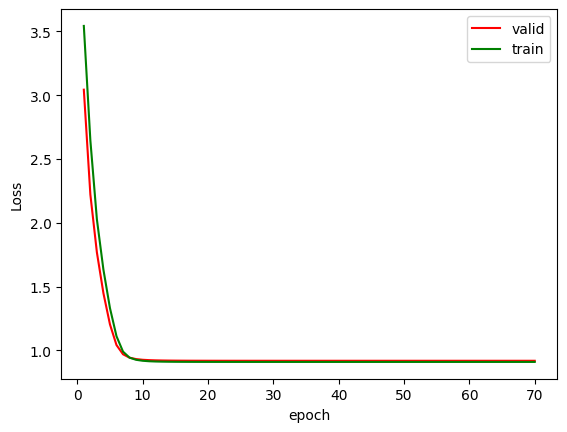

In [16]:
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1), all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,epochs+1), all_train_loss, color = "green", label='train')
plt.legend()

- Binary clf case

In [17]:
# Hyper parameters
embed_dim = 60
batch_size = 1024
epochs = 70
lr = 0.001
weight_decay = 0.001
device = 'cpu'
optimizer = "Adam"
optims = {"SGD": SGD, "Adam": Adam}
Binclf = True

dataset = MovieLensDataset(index_data, Binclf)
train_len = int(len(dataset)*0.8)
valid_len = int(len(dataset)*0.1)
test_len = len(dataset) - train_len - valid_len

train_dataset, valid_dataset, test_dataset = random_split(dataset, (train_len, valid_len, test_len))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

field_dims = dataset.field_dims

model = FM(field_dims, embed_dim, Binclf)
criterion = nn.BCELoss() if Binclf else RMSE
metric = roc_auc_score if Binclf else RMSE

best_loss = 1e5
best_epoch = 1
all_train_loss = []
all_valid_loss = []

for epoch in range(1, epochs+1):
    train_loss = train(model, optims[optimizer](params=model.parameters(), lr=lr, weight_decay=weight_decay), train_dataloader, criterion, device)
    pred, valid_loss = eval(model, valid_dataloader, device, criterion)

    print(f'EPOCH : {epoch:2} | Train Loss : {train_loss:.6f} | Valid Loss : {valid_loss:.6f}')

    all_train_loss.append(train_loss)
    all_valid_loss.append(valid_loss)

    if valid_loss < best_loss:
        best_loss = valid_loss
        best_epoch = epoch

print(f'BEST EPOCH : {best_epoch} | Best Valid Loss : {best_loss}')

  0%|          | 0/79 [00:00<?, ?it/s]

100%|██████████| 79/79 [00:00<00:00, 113.41it/s]


EPOCH :  1 | Train Loss : 0.899378 | Valid Loss : 0.887729


100%|██████████| 79/79 [00:00<00:00, 127.33it/s]


EPOCH :  2 | Train Loss : 0.866772 | Valid Loss : 0.856852


100%|██████████| 79/79 [00:00<00:00, 141.98it/s]


EPOCH :  3 | Train Loss : 0.837211 | Valid Loss : 0.829051


100%|██████████| 79/79 [00:00<00:00, 114.61it/s]


EPOCH :  4 | Train Loss : 0.810672 | Valid Loss : 0.804269


100%|██████████| 79/79 [00:00<00:00, 126.20it/s]


EPOCH :  5 | Train Loss : 0.787108 | Valid Loss : 0.782388


100%|██████████| 79/79 [00:00<00:00, 127.92it/s]


EPOCH :  6 | Train Loss : 0.766395 | Valid Loss : 0.763204


100%|██████████| 79/79 [00:00<00:00, 128.05it/s]


EPOCH :  7 | Train Loss : 0.748316 | Valid Loss : 0.746326


100%|██████████| 79/79 [00:00<00:00, 126.58it/s]


EPOCH :  8 | Train Loss : 0.732349 | Valid Loss : 0.731110


100%|██████████| 79/79 [00:00<00:00, 126.54it/s]


EPOCH :  9 | Train Loss : 0.717901 | Valid Loss : 0.717158


100%|██████████| 79/79 [00:00<00:00, 127.18it/s]


EPOCH : 10 | Train Loss : 0.704714 | Valid Loss : 0.704380


100%|██████████| 79/79 [00:00<00:00, 126.58it/s]


EPOCH : 11 | Train Loss : 0.692699 | Valid Loss : 0.692724


100%|██████████| 79/79 [00:00<00:00, 126.81it/s]


EPOCH : 12 | Train Loss : 0.681796 | Valid Loss : 0.682175


100%|██████████| 79/79 [00:00<00:00, 126.22it/s]


EPOCH : 13 | Train Loss : 0.671954 | Valid Loss : 0.672686


100%|██████████| 79/79 [00:00<00:00, 126.60it/s]


EPOCH : 14 | Train Loss : 0.663092 | Valid Loss : 0.664189


100%|██████████| 79/79 [00:00<00:00, 126.58it/s]


EPOCH : 15 | Train Loss : 0.655152 | Valid Loss : 0.656598


100%|██████████| 79/79 [00:00<00:00, 125.90it/s]


EPOCH : 16 | Train Loss : 0.648078 | Valid Loss : 0.649872


100%|██████████| 79/79 [00:00<00:00, 114.80it/s]


EPOCH : 17 | Train Loss : 0.641797 | Valid Loss : 0.643954


100%|██████████| 79/79 [00:00<00:00, 125.94it/s]


EPOCH : 18 | Train Loss : 0.636237 | Valid Loss : 0.638735


100%|██████████| 79/79 [00:00<00:00, 126.66it/s]


EPOCH : 19 | Train Loss : 0.631343 | Valid Loss : 0.634150


100%|██████████| 79/79 [00:00<00:00, 126.88it/s]


EPOCH : 20 | Train Loss : 0.627041 | Valid Loss : 0.630141


100%|██████████| 79/79 [00:00<00:00, 126.90it/s]


EPOCH : 21 | Train Loss : 0.623262 | Valid Loss : 0.626633


100%|██████████| 79/79 [00:00<00:00, 140.89it/s]


EPOCH : 22 | Train Loss : 0.619950 | Valid Loss : 0.623558


100%|██████████| 79/79 [00:00<00:00, 127.35it/s]


EPOCH : 23 | Train Loss : 0.617061 | Valid Loss : 0.620888


100%|██████████| 79/79 [00:00<00:00, 127.91it/s]


EPOCH : 24 | Train Loss : 0.614541 | Valid Loss : 0.618564


100%|██████████| 79/79 [00:00<00:00, 142.27it/s]


EPOCH : 25 | Train Loss : 0.612351 | Valid Loss : 0.616551


100%|██████████| 79/79 [00:00<00:00, 115.33it/s]


EPOCH : 26 | Train Loss : 0.610449 | Valid Loss : 0.614801


100%|██████████| 79/79 [00:00<00:00, 121.65it/s]


EPOCH : 27 | Train Loss : 0.608789 | Valid Loss : 0.613269


100%|██████████| 79/79 [00:00<00:00, 126.07it/s]


EPOCH : 28 | Train Loss : 0.607343 | Valid Loss : 0.611930


100%|██████████| 79/79 [00:00<00:00, 126.44it/s]


EPOCH : 29 | Train Loss : 0.606083 | Valid Loss : 0.610760


100%|██████████| 79/79 [00:00<00:00, 126.22it/s]


EPOCH : 30 | Train Loss : 0.604984 | Valid Loss : 0.609731


100%|██████████| 79/79 [00:00<00:00, 126.35it/s]


EPOCH : 31 | Train Loss : 0.604030 | Valid Loss : 0.608826


100%|██████████| 79/79 [00:00<00:00, 126.51it/s]


EPOCH : 32 | Train Loss : 0.603200 | Valid Loss : 0.608028


100%|██████████| 79/79 [00:00<00:00, 126.42it/s]


EPOCH : 33 | Train Loss : 0.602480 | Valid Loss : 0.607330


100%|██████████| 79/79 [00:00<00:00, 111.59it/s]


EPOCH : 34 | Train Loss : 0.601852 | Valid Loss : 0.606724


100%|██████████| 79/79 [00:00<00:00, 127.09it/s]


EPOCH : 35 | Train Loss : 0.601309 | Valid Loss : 0.606206


100%|██████████| 79/79 [00:00<00:00, 126.17it/s]


EPOCH : 36 | Train Loss : 0.600838 | Valid Loss : 0.605756


100%|██████████| 79/79 [00:00<00:00, 127.48it/s]


EPOCH : 37 | Train Loss : 0.600430 | Valid Loss : 0.605369


100%|██████████| 79/79 [00:00<00:00, 125.80it/s]


EPOCH : 38 | Train Loss : 0.600076 | Valid Loss : 0.605033


100%|██████████| 79/79 [00:00<00:00, 140.93it/s]


EPOCH : 39 | Train Loss : 0.599772 | Valid Loss : 0.604741


100%|██████████| 79/79 [00:00<00:00, 127.34it/s]


EPOCH : 40 | Train Loss : 0.599509 | Valid Loss : 0.604486


100%|██████████| 79/79 [00:00<00:00, 127.39it/s]


EPOCH : 41 | Train Loss : 0.599283 | Valid Loss : 0.604263


100%|██████████| 79/79 [00:00<00:00, 141.99it/s]


EPOCH : 42 | Train Loss : 0.599088 | Valid Loss : 0.604068


100%|██████████| 79/79 [00:00<00:00, 114.30it/s]


EPOCH : 43 | Train Loss : 0.598920 | Valid Loss : 0.603898


100%|██████████| 79/79 [00:00<00:00, 126.58it/s]


EPOCH : 44 | Train Loss : 0.598777 | Valid Loss : 0.603749


100%|██████████| 79/79 [00:00<00:00, 125.85it/s]


EPOCH : 45 | Train Loss : 0.598655 | Valid Loss : 0.603620


100%|██████████| 79/79 [00:00<00:00, 126.42it/s]


EPOCH : 46 | Train Loss : 0.598549 | Valid Loss : 0.603508


100%|██████████| 79/79 [00:00<00:00, 126.48it/s]


EPOCH : 47 | Train Loss : 0.598457 | Valid Loss : 0.603413


100%|██████████| 79/79 [00:00<00:00, 126.44it/s]


EPOCH : 48 | Train Loss : 0.598377 | Valid Loss : 0.603332


100%|██████████| 79/79 [00:00<00:00, 126.55it/s]


EPOCH : 49 | Train Loss : 0.598307 | Valid Loss : 0.603262


100%|██████████| 79/79 [00:00<00:00, 122.03it/s]


EPOCH : 50 | Train Loss : 0.598245 | Valid Loss : 0.603201


100%|██████████| 79/79 [00:00<00:00, 113.96it/s]


EPOCH : 51 | Train Loss : 0.598191 | Valid Loss : 0.603149


100%|██████████| 79/79 [00:00<00:00, 126.82it/s]


EPOCH : 52 | Train Loss : 0.598144 | Valid Loss : 0.603104


100%|██████████| 79/79 [00:00<00:00, 126.52it/s]


EPOCH : 53 | Train Loss : 0.598101 | Valid Loss : 0.603065


100%|██████████| 79/79 [00:00<00:00, 126.31it/s]


EPOCH : 54 | Train Loss : 0.598064 | Valid Loss : 0.603031


100%|██████████| 79/79 [00:00<00:00, 125.54it/s]


EPOCH : 55 | Train Loss : 0.598032 | Valid Loss : 0.603003


100%|██████████| 79/79 [00:00<00:00, 140.06it/s]


EPOCH : 56 | Train Loss : 0.598004 | Valid Loss : 0.602978


100%|██████████| 79/79 [00:00<00:00, 126.46it/s]


EPOCH : 57 | Train Loss : 0.597981 | Valid Loss : 0.602958


100%|██████████| 79/79 [00:00<00:00, 123.35it/s]


EPOCH : 58 | Train Loss : 0.597963 | Valid Loss : 0.602942


100%|██████████| 79/79 [00:00<00:00, 143.19it/s]


EPOCH : 59 | Train Loss : 0.597947 | Valid Loss : 0.602929


100%|██████████| 79/79 [00:00<00:00, 115.37it/s]


EPOCH : 60 | Train Loss : 0.597936 | Valid Loss : 0.602919


100%|██████████| 79/79 [00:00<00:00, 126.94it/s]


EPOCH : 61 | Train Loss : 0.597927 | Valid Loss : 0.602911


100%|██████████| 79/79 [00:00<00:00, 127.08it/s]


EPOCH : 62 | Train Loss : 0.597919 | Valid Loss : 0.602904


100%|██████████| 79/79 [00:00<00:00, 127.22it/s]


EPOCH : 63 | Train Loss : 0.597914 | Valid Loss : 0.602900


100%|██████████| 79/79 [00:00<00:00, 126.75it/s]


EPOCH : 64 | Train Loss : 0.597910 | Valid Loss : 0.602895


100%|██████████| 79/79 [00:00<00:00, 125.57it/s]


EPOCH : 65 | Train Loss : 0.597906 | Valid Loss : 0.602892


100%|██████████| 79/79 [00:00<00:00, 126.94it/s]


EPOCH : 66 | Train Loss : 0.597904 | Valid Loss : 0.602889


100%|██████████| 79/79 [00:00<00:00, 122.13it/s]


EPOCH : 67 | Train Loss : 0.597902 | Valid Loss : 0.602888


100%|██████████| 79/79 [00:00<00:00, 114.93it/s]


EPOCH : 68 | Train Loss : 0.597901 | Valid Loss : 0.602886


100%|██████████| 79/79 [00:00<00:00, 126.96it/s]


EPOCH : 69 | Train Loss : 0.597898 | Valid Loss : 0.602884


100%|██████████| 79/79 [00:00<00:00, 127.01it/s]

EPOCH : 70 | Train Loss : 0.597898 | Valid Loss : 0.602883
BEST EPOCH : 70 | Best Valid Loss : 0.6028828767553936


test score : 0.7444004138132123
tensor([0., 1., 1.,  ..., 1., 1., 1.], dtype=torch.float64) tensor([0.2666, 0.6615, 0.5855,  ..., 0.7777, 0.7167, 0.7353],
       dtype=torch.float64)


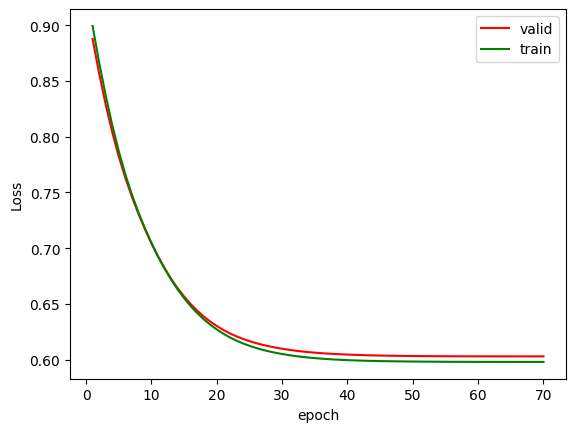

In [18]:
pred, _ = eval(model, test_dataloader, device, criterion)
target = dataset.targets[test_dataset.indices]
print(f'test score : {metric(target,pred)}')
print(target, pred)

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1), all_valid_loss, color = "red", label='valid') 
plt.plot(range(1,epochs+1), all_train_loss, color = "green", label='train')
plt.legend()
